# Spectral clustering

You can use Laplace spectra to cluster data. The idea is that the eigenvalues of the mesh's Laplace spectrum can be embedded in a lower-dimensional space.

Data source for this notebooks: https://github.com/odedstein/meshes


In [3]:
import os
import glob
import napari_shape_odyssey as nso
import vedo
import numpy as np
import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

import napari
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
!git clone https://github.com/odedstein/meshes.git

Cloning into 'meshes'...
Updating files:  17% (17/96)
Updating files:  18% (18/96)
Updating files:  19% (19/96)
Updating files:  20% (20/96)
Updating files:  21% (21/96)
Updating files:  22% (22/96)
Updating files:  23% (23/96)
Updating files:  25% (24/96)
Updating files:  26% (25/96)
Updating files:  27% (26/96)
Updating files:  28% (27/96)
Updating files:  29% (28/96)
Updating files:  30% (29/96)
Updating files:  31% (30/96)
Updating files:  32% (31/96)
Updating files:  33% (32/96)
Updating files:  34% (33/96)
Updating files:  35% (34/96)
Updating files:  36% (35/96)
Updating files:  37% (36/96)
Updating files:  38% (37/96)
Updating files:  39% (38/96)
Updating files:  40% (39/96)
Updating files:  41% (40/96)
Updating files:  42% (41/96)
Updating files:  43% (42/96)
Updating files:  44% (43/96)
Updating files:  45% (44/96)
Updating files:  46% (45/96)
Updating files:  47% (46/96)
Updating files:  48% (47/96)
Updating files:  50% (48/96)
Updating files:  51% (49/96)
Updating files:  5

In [4]:
mesh_files = glob.glob(os.path.join('./meshes/**/*.obj'))

In [4]:
viewer = napari.Viewer()

## Calculate spectra for every mesh

In [ ]:
eigenvalues = []
eigenvectors = []
meshes = []
for file in tqdm.tqdm(mesh_files):
    # load and preprocess meshes
    mesh = vedo.load(file).triangulate().clean().decimate(n=5000)
    bounding_box_volume = np.prod(mesh.bounds()[1] - mesh.bounds()[0])
    mesh.scale(1 / bounding_box_volume)

    mesh_tuple = (mesh.points(), np.asarray(mesh.faces()))
    meshes.append(mesh_tuple)
    viewer.add_surface(mesh_tuple, name = os.path.basename(file))
    _eigenvectors, _eigenvalues = nso.spectral.shape_fingerprint(mesh_tuple, order = 20)

    eigenvalues.append(_eigenvalues)
    eigenvectors.append(_eigenvectors)

In [19]:
# stack eigenvalues into dataframe
eigenvalues_stack = np.stack(eigenvalues)
df = pd.DataFrame(eigenvalues_stack, columns = [f'lambda_{i}' for i in range(eigenvalues_stack.shape[1])])
df.head()

,lambda_0,lambda_1,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6,lambda_7,lambda_8,lambda_9,lambda_10,lambda_11,lambda_12,lambda_13,lambda_14,lambda_15,lambda_16,lambda_17,lambda_18,lambda_19
0,-1.953646e-14,3.497411,4.534560,5.684497,9.985113,14.893090,22.529184,29.669639,30.541655,37.723114,41.284098,52.551030,58.486390,63.681724,64.850003,71.539644,78.696079,81.764765,95.658377,102.104163
1,1.382054e-14,3.497411,4.534560,5.684497,9.985113,14.893090,22.529184,29.669640,30.541655,37.723113,41.284097,52.551029,58.486391,63.681721,64.850001,71.539641,78.696077,81.764764,95.658375,102.104161
2,-2.596881e-15,0.683063,2.141403,4.065282,4.768848,4.828398,7.341017,7.398343,7.880799,10.123669,10.174560,11.785636,13.405222,14.186425,15.805213,16.056310,16.568611,18.689970,19.308144,21.437427
3,-3.480202e-14,7.361894,14.320784,29.855033,33.864331,38.218302,51.627914,55.100373,63.052792,71.963617,75.823578,91.888147,95.434760,99.987659,114.406247,123.437142,127.149471,140.136072,142.793974,153.672580
4,8.763823e-15,5.616643,7.917237,8.444330,16.360097,19.160159,20.802747,22.530132,30.035678,35.645911,37.769361,40.187326,41.239513,45.143890,48.583533,55.172578,60.318931,60.867925,64.006032,70.048105


## Normalize spectra

In [ ]:
# Fit a linear curve to every row of the dataframe and divide every value in the row by the slope of the curve

slope = []
intercept = []
for i in range(0, len(df)):
    x = np.arange(0, len(df.columns))
    y = df.iloc[i].values
    m, b = np.polyfit(x, y, 1)
    slope.append(m)
    intercept.append(b)

df = df.div(slope, axis=0)

## Dimensionality reduction

In [ ]:
embedder = TSNE(n_components=2)
X_embedded = embedder.fit_transform(df)

clusterer = DBSCAN(eps=0.25, min_samples=2)
clusterer.fit(X_embedded)

for idx, layer in enumerate(viewer.layers):
    mesh_tuple = list(layer.data)
    mesh_tuple[-1] *= clusterer.labels_[idx]
    viewer.layers[idx].data = tuple(mesh_tuple)
    viewer.layers[idx].colormap = 'tab10'
    viewer.layers[idx].contrast_limits = [-1, np.max(clusterer.labels_)]


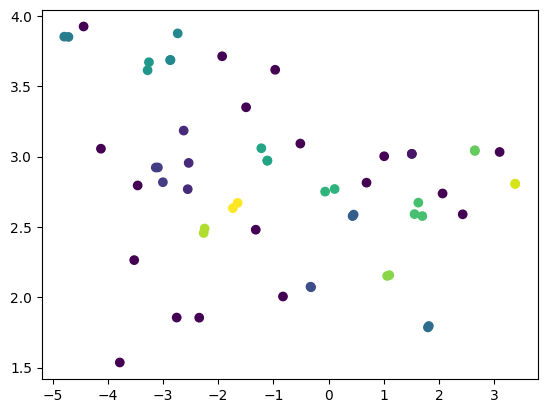

In [22]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = clusterer.labels_)

In [98]:
for idx in np.argwhere(clusterer.labels_==4):
    viewer.add_surface(meshes[idx[0]], name = os.path.basename(mesh_files[idx[0]]))